<a href="https://colab.research.google.com/github/tb000330/BPA_Lab/blob/main/Abnomal%20Detection/timeseries_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://app.neptune.ai/theaayushbajaj/Anomaly-Detection/n/49ba1752-fc3a-4abb-b35f-0e2ea4fd4afa/48dc19d8-3c75-4989-a2c0-67839393a093
# https://neptune.ai/blog/anomaly-detection-in-time-series
# https://kh-kim.github.io/blog/2020/06/24/time-series-ad.html (RNN)
# https://zephyrus1111.tistory.com/78

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime

from tqdm import tqdm

from IPython.display import display
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [ ]:
pd.set_option('display.max_row', None)

# #1. 전처리

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/학교/LAB/항법세트.csv')
df = df.drop(['사업장명', '검사구분', '자재코드', '자재명', '샘플번호', '검사키'], axis=1)

str_list = ['식별번호 일치여부', '부품 정상조립 여부', '보호피막 처리 누락 및 결함여부', 'S/W 버전 확인_PC전시화면', 'S/W 버전 확인_시험 프로그램', '초기고장배제 진동시험, 온도시험']

# 검사항목 pass/unpass drop
for s in str_list:
    df = df[df['검사항목']!=s]

## 2. 검사항목 별 검사값 상관계수
df = df[['검사요청번호', '검사항목', '검사값']]
df_cor = df.pivot_table(index='검사요청번호', columns='검사항목', values='검사값')
df_cor.columns = ['pe_head', 'att_head', 'pe_pitch', 'att_pitch', 'pe_roll', 'att_roll', 'current', 'voltage', 'pe_repeat', 'weight', 'set_0', 'set_180', 'set_90', 'set_270']
df_cor

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
검사요청번호,,,,,,,,,,,,,,
OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800
OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610
OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750
OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227
OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777
OQ-20201123-00005,0.018,0.484,0.044,0.178,0.062,0.236,2.157,28.008,0.385,17.69,520.628,1999.445,277.235,1151.542
OQ-20201123-00006,0.016,0.337,0.048,0.096,0.062,0.128,2.203,28.005,0.250,17.71,490.279,1410.147,466.200,1789.714
OQ-20201123-00007,0.019,0.052,0.047,0.067,0.063,0.072,2.167,28.015,0.439,17.73,223.668,1354.981,201.620,2039.475
OQ-20201211-00005,0.050,0.160,0.050,0.120,0.060,0.170,2.200,28.000,0.270,17.70,623.400,2200.200,630.300,1865.600


In [ ]:
df_cor = df_cor.reset_index()
df_cor['datetime'] = df_cor['검사요청번호'].str.slice(start=3, stop=11)
df_cor['datetime'] = pd.to_datetime(df_cor['datetime'], format='%Y%m%d')
df_cor

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime
0,OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800,2020-10-06
1,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610,2020-10-29
2,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750,2020-10-29
3,OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227,2020-11-12
4,OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777,2020-11-19
5,OQ-20201123-00005,0.018,0.484,0.044,0.178,0.062,0.236,2.157,28.008,0.385,17.69,520.628,1999.445,277.235,1151.542,2020-11-23
6,OQ-20201123-00006,0.016,0.337,0.048,0.096,0.062,0.128,2.203,28.005,0.250,17.71,490.279,1410.147,466.200,1789.714,2020-11-23
7,OQ-20201123-00007,0.019,0.052,0.047,0.067,0.063,0.072,2.167,28.015,0.439,17.73,223.668,1354.981,201.620,2039.475,2020-11-23
8,OQ-20201211-00005,0.050,0.160,0.050,0.120,0.060,0.170,2.200,28.000,0.270,17.70,623.400,2200.200,630.300,1865.600,2020-12-11
9,OQ-20201217-00002,0.020,0.130,0.040,0.090,0.060,0.130,2.200,28.000,0.310,17.70,290.000,356.200,240.300,792.200,2020-12-17


In [ ]:
df_cor.groupby('datetime')['datetime'].count()
export = pd.DataFrame(df_cor.groupby('datetime')['datetime'].count())
export
# export.to_csv('/content/drive/MyDrive/학교/LAB/date.csv')

,datetime
datetime,
2020-10-06,1
2020-10-29,2
2020-11-12,1
2020-11-19,1
2020-11-23,3
2020-12-11,1
2020-12-17,1
2021-01-06,1
2021-01-12,1


## (1) padding 시간단위

In [ ]:
df_num = pd.DataFrame()

for date in df_cor['datetime'].unique():
  date_i = df_cor[df_cor['datetime']==date].reset_index(drop=True).reset_index()
  date_i['index'] = date_i['index'].astype(str)

  date_i['datetime_num'] = date_i['검사요청번호'].str.slice(start=3, stop=11) + '0' + date_i['index']
  df_num = df_num.append(date_i)

df_num = df_num.drop(['index'], axis=1).reset_index(drop=True)

df_num['datetime_num'] = pd.to_datetime(df_num['datetime_num'], format='%Y%m%d%H')
df_num

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime,datetime_num
0,OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800,2020-10-06,2020-10-06 00:00:00
1,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610,2020-10-29,2020-10-29 00:00:00
2,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750,2020-10-29,2020-10-29 01:00:00
3,OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227,2020-11-12,2020-11-12 00:00:00
4,OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777,2020-11-19,2020-11-19 00:00:00
5,OQ-20201123-00005,0.018,0.484,0.044,0.178,0.062,0.236,2.157,28.008,0.385,17.69,520.628,1999.445,277.235,1151.542,2020-11-23,2020-11-23 00:00:00
6,OQ-20201123-00006,0.016,0.337,0.048,0.096,0.062,0.128,2.203,28.005,0.250,17.71,490.279,1410.147,466.200,1789.714,2020-11-23,2020-11-23 01:00:00
7,OQ-20201123-00007,0.019,0.052,0.047,0.067,0.063,0.072,2.167,28.015,0.439,17.73,223.668,1354.981,201.620,2039.475,2020-11-23,2020-11-23 02:00:00
8,OQ-20201211-00005,0.050,0.160,0.050,0.120,0.060,0.170,2.200,28.000,0.270,17.70,623.400,2200.200,630.300,1865.600,2020-12-11,2020-12-11 00:00:00
9,OQ-20201217-00002,0.020,0.130,0.040,0.090,0.060,0.130,2.200,28.000,0.310,17.70,290.000,356.200,240.300,792.200,2020-12-17,2020-12-17 00:00:00


In [ ]:
df_num_pad = df_num.set_index('datetime_num').asfreq('H', method='pad')
df_num_pad[df_num_pad['datetime']=='2020-10-29']

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime
datetime_num,,,,,,,,,,,,,,,,
2020-10-29 00:00:00,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.73,904.77,182.04,409.61,2020-10-29
2020-10-29 01:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 02:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 03:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 04:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 05:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 06:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 07:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 08:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29


## (2) 중복 datetime 다른 날짜로 분리

In [ ]:
# df_dup = df_cor.copy()
# df_dup['datetime'] = df_dup['datetime'].astype(str)
# dup_date = pd.DataFrame(df_dup.groupby(['datetime']).count())
# dup_date = dup_date[dup_date['검사요청번호']>1].reset_index()['datetime']
# dup_date

In [ ]:
# for date in dup_date.values:
#   date_index = df_dup[df_dup['datetime'] == date].index
#   for ind in range(len(date_index)):
#     if ind == 0:
#       pass
#     else:
#       dup_index = date_index[ind]
#       df_dup['datetime'][dup_index] = str(pd.to_datetime(date)+pd.DateOffset(days=ind))[:10]

# # 중복날짜 없는 지 확인
# (df_dup.groupby('datetime')['datetime'].count() > 1).unique()

In [ ]:
# df_dup['datetime'] = pd.to_datetime(df_dup['datetime'])
# df_dup

In [ ]:
# group1 = df_dup[['pe_repeat','att_head', 'datetime']]
# group2 = df_dup[['pe_head','pe_pitch','pe_roll', 'datetime']]
# group3 = df_dup[['att_pitch', 'att_roll', 'datetime']]
# group4 = df_dup[['set_0','set_90', 'datetime']]
# group5 = df_dup[['set_180', 'set_270', 'datetime']]
# group6 = df_dup[['current', 'datetime']]
# group7 = df_dup[['voltage', 'datetime']]
# group8 = df_dup[['weight', 'datetime']]

## (3) 상관관계

In [ ]:
group1 = df_num[['pe_repeat','att_head', 'datetime']]
group2 = df_num[['pe_head','pe_pitch','pe_roll', 'datetime']]
group3 = df_num[['att_pitch', 'att_roll', 'datetime']]
group4 = df_num[['set_0','set_90', 'datetime']]
group5 = df_num[['set_180', 'set_270', 'datetime']]
group6 = df_num[['current', 'datetime']]
group7 = df_num[['voltage', 'datetime']]
group8 = df_num[['weight', 'datetime']]

In [ ]:
df_num.corr(method='pearson')

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,-0.134285,0.038843,-0.036506,-0.017810,-0.034870,-0.059390,-0.128709,-0.061265,0.046910,0.056097,0.010547,0.112893,-0.120901
att_head,-0.134285,1.000000,0.068467,0.414388,0.104822,0.345653,0.086073,0.085250,0.066906,-0.171648,-0.061532,0.157021,0.167591,0.029178
pe_pitch,0.038843,0.068467,1.000000,0.013995,0.968736,-0.078624,0.237847,0.267870,-0.006799,-0.457198,-0.116934,0.163562,-0.077100,0.121748
att_pitch,-0.036506,0.414388,0.013995,1.000000,0.002308,0.960810,-0.089238,0.039908,0.114537,-0.182366,-0.123451,-0.026061,0.047226,0.006031
pe_roll,-0.017810,0.104822,0.968736,0.002308,1.000000,-0.103833,0.218505,0.320142,-0.029204,-0.425309,-0.126235,0.151931,-0.081699,0.089636
att_roll,-0.034870,0.345653,-0.078624,0.960810,-0.103833,1.000000,-0.081819,-0.032482,0.078933,-0.162815,-0.121437,-0.040674,0.061060,0.016418
current,-0.059390,0.086073,0.237847,-0.089238,0.218505,-0.081819,1.000000,0.095071,0.061431,-0.320327,0.219890,0.246957,0.134822,0.212940
voltage,-0.128709,0.085250,0.267870,0.039908,0.320142,-0.032482,0.095071,1.000000,0.092878,0.026038,-0.142567,0.036721,-0.151064,0.046233
pe_repeat,-0.061265,0.066906,-0.006799,0.114537,-0.029204,0.078933,0.061431,0.092878,1.000000,-0.038647,0.164696,-0.014912,0.069561,0.033028
weight,0.046910,-0.171648,-0.457198,-0.182366,-0.425309,-0.162815,-0.320327,0.026038,-0.038647,1.000000,0.088328,-0.109533,-0.069946,-0.054024


In [ ]:
def group_timeline(*df):
  fig, axs = plt.subplots(figsize=(15,8*len(df)), nrows=len(df), ncols=1)
  
  for inx, group in enumerate(df):
    group = group.set_index('datetime')
    for col in group.columns:
      axs[inx].plot(group[col], label=str(col))
    axs[inx].legend(loc=(1.01, 0.8))
    axs[inx].set_title('Group'+str(inx+1), fontsize=20)
    axs[inx].set_ylabel('Measures', fontsize=16)
    # axs[inx].tick_params(labelrotation=45, labelsize='8')

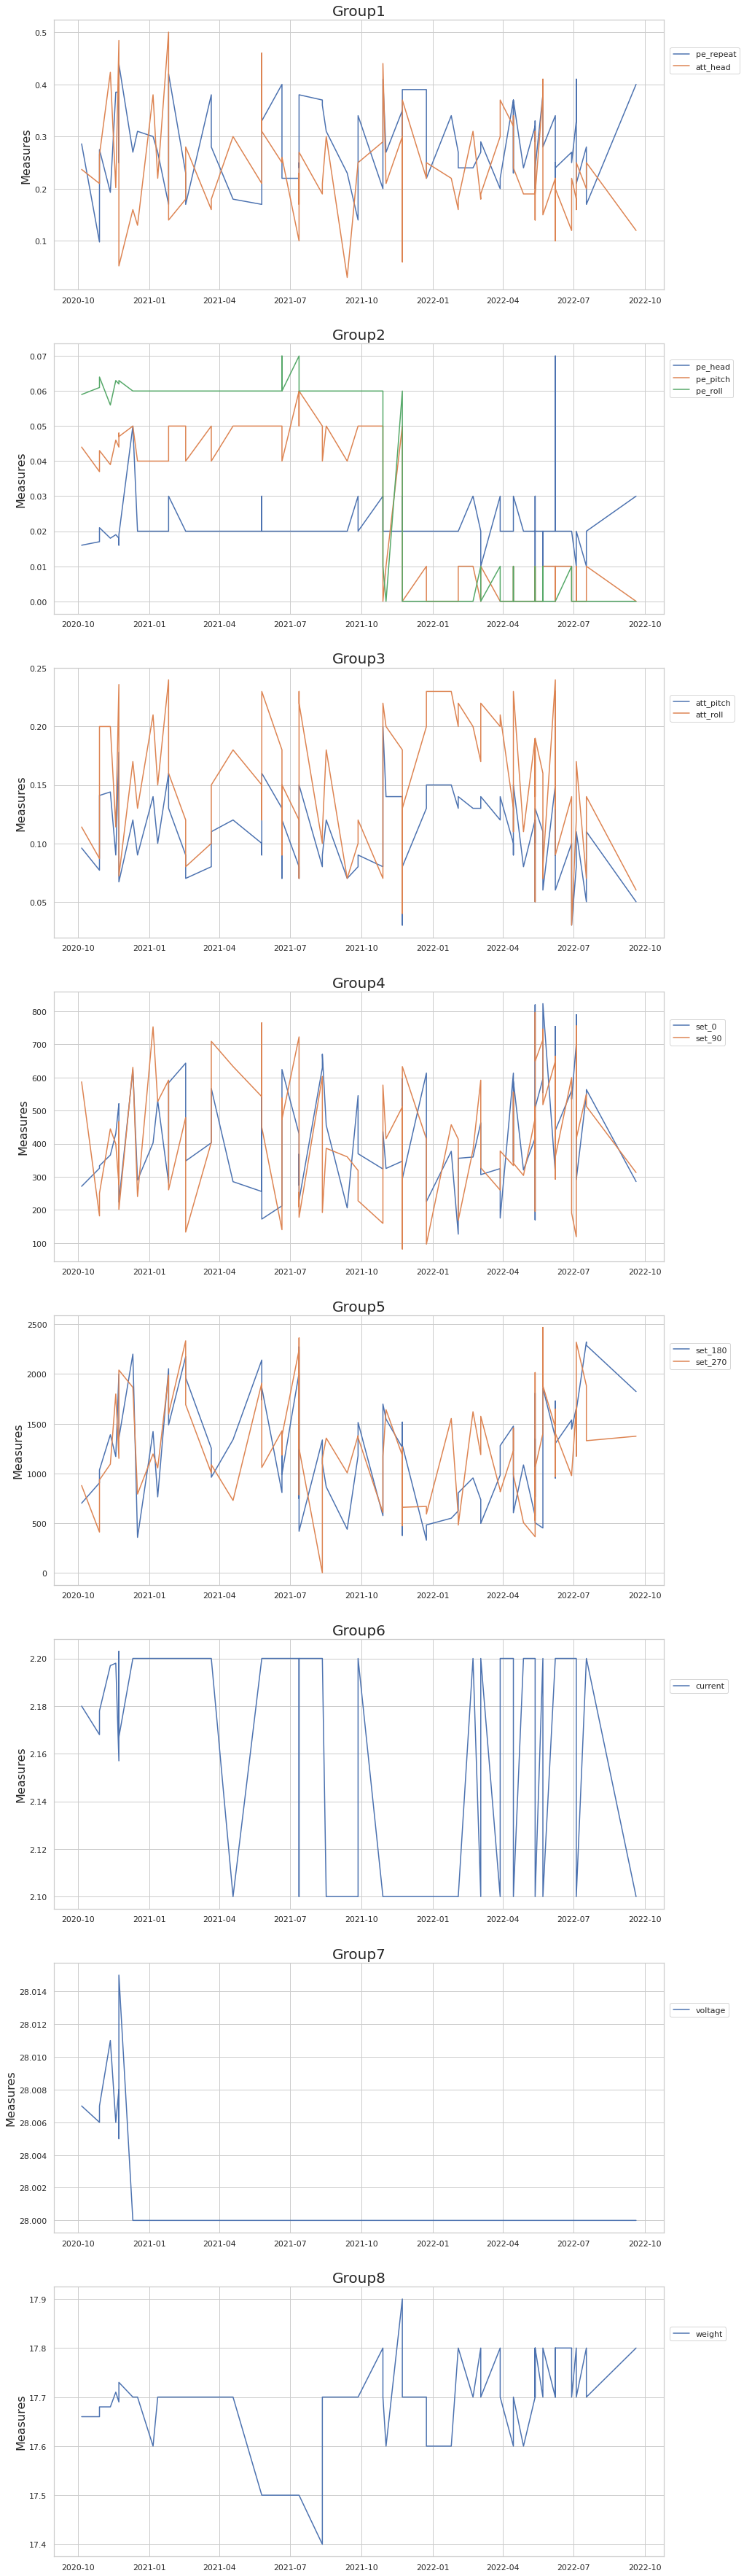

In [ ]:
group_timeline(group1, group2, group3, group4, group5, group6, group7, group8)

# #2. 이상치 탐지

## (1) Seasonal Decompose
- https://cran.r-project.org/web/packages/anomalize/vignettes/anomalize_quick_start_guide.html

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import statsmodels as sm
import statsmodels.api as sm

In [ ]:
def seasonal_plot(*df):
  for inx, group in enumerate(df):
    # group = group.set_index('datetime').asfreq('D', method='pad')
    for col in group.columns:
      decomposition = seasonal_decompose(group[col],model='additive') #multiplicative
      decomposition.plot()

  return decomposition

In [ ]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

decomposition = seasonal_plot(group2)

NameError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

x = decomposition.resid.index
y = decomposition.resid.values

ax.plot_date(x, y, color='black',linestyle='--')
ax.fill_between(x, 0-0.05, 0+0.05, alpha=0.5)
# ax.annotate('Anomaly', (mdates.date2num(x[700]), y[700]), xytext=(30, 20), textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
# fig.autofmt_xdate()
plt.show()

## (2) Isolation Forest

  - Isolation Forest가 정상 데이터 지점을 프로파일링하는 대신 이상 징후를 명시적으로 식별한다는 것이다. 격리 포레스트는 다른 트리 앙상블 방법과 마찬가지로 의사결정 트리를 기반으로 한다.
  - Isolation Forest는 이상 징후가 소수이고 서로 다른 데이터 지점이라는 사실을 기반으로 이상 징후를 탐지합니다. 이상 분리는 거리 또는 밀도 측정을 사용하지 않고 구현된다.
  - 격리 포레스트 모델을 적용할 때 오염 = 특이치_이상치를 설정. 
  즉, 데이터에 특이치의 비율이 어느 정도인지를 모델에 알려줍니다. (시행착오 메트릭)
 - 적합 및 예측(데이터)은 데이터에 대해 특이치 탐지를 수행하고 정규 분포의 경우 변칙 분포의 경우 -1을 반환
 - 마지막으로, 우리는 시계열 보기로 이상 징후를 시각화.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [ ]:
# def isolation_forest(df,ratio):

def isolation_forest(df,columns,ratio):
  group_result = pd.DataFrame()

  # for columns in df.columns:
    # if columns != 'datetime':
  #     group = df[[df, 'datetime']].set_index('datetime')
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  outliers_fraction = float(ratio) ## 이상치 비율설정

  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  data = pd.DataFrame(np_scaled)

  model = IsolationForest(contamination=outliers_fraction)
  model.fit(data)
  group['isolation_anomaly'] = model.predict(data)

  group_result = group_result.append(group[group.columns])

    # # visualization
    # fig, ax = plt.subplots(figsize=(10,6))

      # a = group.loc[group['isolation_anomaly'+'_'+str(columns)] == -1, [columns]] #anomaly

      # ax.plot(group.index, group[columns], color='black', label = 'Normal')
      # ax.scatter(a.index,a[columns], color='red', label = 'Anomaly')
      # plt.legend(loc=(1.01, 0.8))
      # plt.title(str(columns))
      # plt.show()
    

  return group_result

# isolation_result = isolation_forest(group5, .05)

In [ ]:
isolation_df = pd.DataFrame()

for col in df_num.columns[1:15]:
  isolation_result = isolation_forest(df_num, col, .05)
  isolation_result['col'] = str(col)

  isolation_df = isolation_df.append(isolation_result[isolation_result['isolation_anomaly']==-1])

isolation_df[['isolation_anomaly', 'col']]

[-0.59789366 -0.61181567 -0.64346417 -0.55195557 -0.53874883 -0.55195557
 -0.59789366 -0.53874883 -0.79631772 -0.32446418 -0.32446418 -0.32446418
 -0.32446418 -0.53635353 -0.32446418 -0.32446418 -0.32446418 -0.32446418
 -0.32446418 -0.32446418 -0.53635353 -0.32446418 -0.32446418 -0.32446418
 -0.32446418 -0.32446418 -0.32446418 -0.32446418 -0.32446418 -0.32446418
 -0.32446418 -0.32446418 -0.32446418 -0.32446418 -0.53635353 -0.32446418
 -0.53635353 -0.32446418 -0.32446418 -0.32446418 -0.32446418 -0.32446418
 -0.53635353 -0.32446418 -0.32446418 -0.32446418 -0.32446418 -0.32446418
 -0.32446418 -0.32446418 -0.53635353 -0.32446418 -0.63706037 -0.53635353
 -0.32446418 -0.32446418 -0.32446418 -0.53635353 -0.32446418 -0.32446418
 -0.53635353 -0.32446418 -0.63706037 -0.32446418 -0.32446418 -0.32446418
 -0.63706037 -0.32446418 -0.32446418 -0.32446418 -0.8531507  -0.32446418
 -0.32446418 -0.32446418 -0.32446418 -0.63706037 -0.32446418 -0.32446418
 -0.63706037 -0.32446418 -0.53635353]
[-0.442989   

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

In [ ]:
isolation_df = isolation_df[['isolation_anomaly', 'col']].reset_index()
isolation_df['date'] = isolation_df['datetime_num'].astype(str)
isolation_df['date'] = isolation_df['date'].str.slice(stop=10)
isolation_df

,datetime_num,isolation_anomaly,col,date
0,2020-10-29 01:00:00,-1,pe_head,2020-10-29
1,2020-12-11 00:00:00,-1,pe_head,2020-12-11
2,2022-06-08 02:00:00,-1,pe_head,2022-06-08
3,2020-11-23 00:00:00,-1,att_head,2020-11-23
4,2020-11-23 02:00:00,-1,att_head,2020-11-23
5,2021-01-26 00:00:00,-1,att_head,2021-01-26
6,2021-09-13 00:00:00,-1,att_head,2021-09-13
7,2020-10-29 00:00:00,-1,pe_pitch,2020-10-29
8,2020-11-12 00:00:00,-1,pe_pitch,2020-11-12
9,2021-07-13 00:00:00,-1,pe_pitch,2021-07-13


In [ ]:
isolation_df.groupby('date')['isolation_anomaly'].count().sort_values(ascending=False)

date
2020-11-23    10
2021-07-13     5
2020-10-29     5
2021-11-23     4
2020-11-12     3
2022-05-13     3
2022-07-18     2
2021-12-24     2
2022-07-05     2
2021-01-26     2
2022-05-23     2
2021-08-12     2
2022-06-29     1
2022-06-08     1
2022-02-03     1
2020-10-06     1
2021-10-29     1
2021-09-27     1
2021-06-21     1
2021-05-26     1
2020-12-17     1
2020-12-11     1
2021-09-13     1
Name: isolation_anomaly, dtype: int64

In [ ]:
isolation_count = pd.DataFrame(isolation_df.groupby('date')['isolation_anomaly'].count().sort_values(ascending=False))
export.columns = ['count']
export = export.reset_index()
export['datetime'] = export['datetime'].astype(str)
export = export.set_index('datetime')
export2 = pd.merge(export, isolation_count,left_index=True, right_index=True, how='left')

In [ ]:
isolation_df.groupby(['col'])['isolation_anomaly'].count()

col
att_head     4
att_pitch    3
att_roll     4
current      4
pe_head      3
pe_pitch     4
pe_repeat    4
pe_roll      4
set_0        4
set_180      4
set_270      4
set_90       4
voltage      4
weight       3
Name: isolation_anomaly, dtype: int64

In [ ]:
isolation_df.groupby(['date', 'col'])['isolation_anomaly'].count()

date        col      
2020-10-06  current      1
2020-10-29  current      1
            pe_head      1
            pe_pitch     1
            pe_repeat    1
            pe_roll      1
2020-11-12  pe_pitch     1
            pe_roll      1
            voltage      1
2020-11-23  att_head     1
            att_pitch    1
            att_roll     1
            current      2
            pe_repeat    1
            voltage      3
            weight       1
2020-12-11  pe_head      1
2020-12-17  set_180      1
2021-01-26  att_head     1
            pe_repeat    1
2021-05-26  att_head     1
2021-06-21  pe_roll      1
2021-07-13  pe_pitch     2
            pe_roll      1
            set_270      2
2021-08-12  set_270      1
            weight       1
2021-09-13  att_head     1
2021-09-27  pe_repeat    1
2021-10-29  att_pitch    1
2021-11-23  att_pitch    1
            att_roll     1
            set_90       1
            weight       1
2021-12-24  set_180      1
            set_90       1
2022-0

In [ ]:
isolation_result[isolation_result[isolation_result.columns[1]]==-1][[isolation_result.columns[0], isolation_result.columns[1]]]

,set_270,isolation_anomaly
datetime_num,,
2021-07-13 00:00:00,2242.3,-1
2021-07-13 03:00:00,2362.7,-1
2021-08-12 00:00:00,0.0,-1
2022-05-23 01:00:00,2468.2,-1


In [ ]:
# isolation_result[isolation_result[isolation_result.columns[3]]==-1][[isolation_result.columns[2], isolation_result.columns[3]]]

## (3) Facebook Prophet 
- https://www.analyticsvidhya.com/blog/2021/12/anomaly-detection-model-using-facebook-prophet/
- https://velog.io/@hhhong/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4-05


In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6751887 sha256=c3a0f3d680ee15c1761f211239b9502d3bb468f3bcd9b2828689fafe7fbfd384
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdsta

In [ ]:
!pip install yfinance prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uni

[Prophet]
- Uncertainty in the trend: yhat의 값으로 예측 값의 불확실성 범위 설정
- changepoint_range: 트렌드 변화시점을 명시한 리스트값 설정 가능 범위. 기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정 (Trend 조절 파라미터)
- seasonality_prior_scale: 계절성 반영 강도 (seasonal 조절 파라미터)
- seasonality_mode: 'additive' 또는 'multiplicative' (seasonal 조절 파라미터)
- holiday_prior_scale:	holiday 반영 강도 (Holiday 조절 파라미터)
  
  - Additive는 데이터의 진폭이 일정함을 의미하고, Multiplicative는 데이터의 진폭이 점점 증가하거나 감소


In [ ]:
group = group1[['pe_repeat', 'datetime']]

In [ ]:
from fbprophet import Prophet
import altair as alt
#alt.renderers.enable('notebook')

def fit_predict_model(dataframe, interval_width = 0.95, changepoint_range = 0.8): #interval_width 이상치 범위 설정
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
               seasonality_mode = 'additive', interval_width = interval_width, changepoint_range = False)
   m = m.fit(dataframe)
   forecast = m.predict(dataframe)
   forecast['real_y'] = dataframe['y'].reset_index(drop = True)
  #  fig = m.plot(forecast)
  #  fig2 = m.plot_components(forecast)
   return forecast

group = group1[['pe_repeat', 'datetime']].rename(columns={'datetime':'ds', 'pe_repeat':'y'})
pred = fit_predict_model(group)

INFO:fbprophet:n_changepoints greater than number of observations. Using -1.


  - 파란색 선이 모델이 예측한 값
  - 검정색 점들이 실제 데이터

In [ ]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'real_y']].copy()

    forecasted['prophet_anomaly'] = 0
    forecasted.loc[forecasted['real_y'] > forecasted['yhat_upper'], 'prophet_anomaly'] = 1
    forecasted.loc[forecasted['real_y'] < forecasted['yhat_lower'], 'prophet_anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['prophet_anomaly'] ==1, 'importance'] = \
        (forecasted['real_y'] - forecasted['yhat_upper'])/forecast['real_y']
    forecasted.loc[forecasted['prophet_anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['real_y'])/forecast['real_y']
    
    return forecasted

prophet_result = detect_anomalies(pred)

In [ ]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'real_y', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.prophet_anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('real_y', title='pe_repeat'),    
        tooltip=['ds', 'real_y', 'yhat_lower', 'yhat_upper']).interactive()

    anomalies = alt.Chart(forecasted[forecasted.prophet_anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('real_y', title='pe_repeat'),    
        tooltip=['ds', 'real_y', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(prophet_result)

alt.LayerChart(...)

- 공정 능력 범위

In [ ]:
prophet_result[prophet_result['prophet_anomaly']!=0]

,ds,trend,yhat,yhat_lower,yhat_upper,real_y,prophet_anomaly,importance
1,2020-10-29,0.281523,0.281523,0.136588,0.438623,0.098,-1,0.393751
7,2020-11-23,0.281560,0.281560,0.134841,0.421787,0.439,1,0.039210


In [ ]:
prophet_df = pd.DataFrame()

for col in df_num.columns[1:15]:
  group = df_num[[col, 'datetime']].rename(columns={'datetime':'ds', col:'y'})
  pred = fit_predict_model(group)
  prophet_result = detect_anomalies(pred)
  prophet_result['col'] = str(col)
  # plot_anomalies(prophet_result)

  prophet_df = prophet_df.append(prophet_result[prophet_result['prophet_anomaly']!=0])

prophet_df

INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.

,ds,trend,yhat,yhat_lower,yhat_upper,real_y,prophet_anomaly,importance,col
8,2020-12-11,0.021151,0.021151,0.006155,0.036811,0.050,1,0.263789,pe_head
70,2022-06-08,0.021591,0.021591,0.006279,0.036143,0.070,1,0.483678,pe_head
5,2020-11-23,0.259223,0.259223,0.066174,0.455998,0.484,1,0.057855,att_head
7,2020-11-23,0.259223,0.259223,0.071975,0.445991,0.052,-1,0.384137,att_head
12,2021-01-26,0.254455,0.254455,0.080603,0.439240,0.500,1,0.121521,att_head
20,2021-05-26,0.245515,0.245515,0.056550,0.442250,0.460,1,0.038586,att_head
33,2021-09-13,0.237320,0.237320,0.051843,0.421836,0.030,-1,0.728096,att_head
37,2021-10-29,0.233893,0.233893,0.040893,0.407062,0.440,1,0.074858,att_head
66,2022-05-23,0.218546,0.218546,0.016817,0.402234,0.410,1,0.018940,att_head
25,2021-07-13,0.033078,0.033078,0.007138,0.059592,0.060,1,0.006803,pe_pitch


In [ ]:
def date_index(export, groupby):
  count = pd.DataFrame(groupby)
  # export.columns = ['count']
  # export = export.reset_index()
  # export['datetime'] = export['datetime'].astype(str)
  # export = export.set_index('datetime')
  export2 = pd.merge(export, count,left_index=True, right_index=True, how='left')

  return export2

date_index(export, prophet_df.reset_index(drop=True).groupby(['ds'])[['col']].count()).to_csv('/content/drive/MyDrive/학교/LAB/date2.csv')

In [ ]:
prophet_df.reset_index(drop=True).groupby(['ds'])[['col']].count()

,col
ds,
2020-10-29,1
2020-11-12,1
2020-11-23,5
2020-12-11,1
2021-01-26,1
2021-02-17,1
2021-05-26,1
2021-07-13,4
2021-08-12,2


In [ ]:
## 규격 고려 (불량률 위험)
prophet_df[(prophet_df['prophet_anomaly']==1)&(prophet_df['col']!='voltage')&(prophet_df['col']!='weight')].groupby(['ds','col'])['prophet_anomaly'].count()

ds          col      
2020-11-23  att_head     1
            pe_repeat    1
2020-12-11  pe_head      1
2021-01-26  att_head     1
2021-02-17  set_270      1
2021-05-26  att_head     1
2021-07-13  pe_pitch     2
            set_180      1
            set_270      1
2021-10-29  att_head     1
            att_pitch    1
            pe_pitch     1
2021-11-23  pe_pitch     1
            pe_roll      2
2022-05-13  set_0        1
2022-05-23  att_head     1
            set_0        1
            set_270      1
2022-06-08  pe_head      1
2022-07-05  set_0        1
            set_270      1
2022-07-18  set_180      2
Name: prophet_anomaly, dtype: int64

## (4) kmeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
data = df_dup.drop(['검사요청번호', 'datetime'], axis=1).copy()
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [ ]:
X = data.copy()
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
# #Plotting
fig,ax = plt.subplots(figsize=(10,6))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

In [ ]:
X = data.copy()
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'y')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [ ]:
# Take useful feature and standardize them
X = data.copy()
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [ ]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

In [ ]:
kmeans[9]

In [ ]:
# https://app.neptune.ai/theaayushbajaj/Anomaly-Detection/n/49ba1752-fc3a-4abb-b35f-0e2ea4fd4afa/48dc19d8-3c75-4989-a2c0-67839393a093
# https://neptune.ai/blog/anomaly-detection-in-time-series
# https://hyperconnect.github.io/2020/03/09/prophet-package.html
# https://kh-kim.github.io/blog/2020/06/24/time-series-ad.html
# https://velog.io/@hhhong/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4-05
# https://zephyrus1111.tistory.com/78
# https://cran.r-project.org/web/packages/anomalize/vignettes/anomalize_quick_start_guide.html
# https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4
# https://www.analyticsvidhya.com/blog/2021/12/anomaly-detection-model-using-facebook-prophet/
# https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders
# https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7 (백분위보다 z-score)

In [ ]:

# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [ ]:
df = df.sort_values('date_time')
#df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly


ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()

## (5) AutoEncoder
- https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders/notebook (딥러닝 이용)
- https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders#Setting-a-threshold-for-classification
- https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7 (백분위보다 z-score)
- https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders


In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=e6ba2770e612c83274b9c9480756393e86853feca4140ac30ee8944bc40ebe0e
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [ ]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib import pyplot, dates

from tqdm import tqdm

### #* 예시 (변수하나)

In [ ]:
auto_df = group1[['pe_repeat', 'datetime']]
auto_df['datetime'] = dates.datestr2num(auto_df['datetime'].astype(str).values)
X_train = StandardScaler().fit_transform(auto_df)
X_train = pd.DataFrame(X_train)
X_train

,0,1
0,0.047413,-1.859653
1,-2.400050,-1.747274
2,-0.095790,-1.747274
3,-1.163300,-1.678869
4,1.336236,-1.644667
5,1.336236,-1.625122
6,-0.421250,-1.625122
7,2.039231,-1.625122
8,-0.160882,-1.537174
9,0.359855,-1.507857


In [ ]:
clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf.fit(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 25)                75        
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f1f728ab940>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
clf.decision_scores_

array([2.10286883, 3.20824601, 2.00872255, 2.32215195, 2.18004492,
       2.16317247, 1.96265916, 2.591228  , 1.81985076, 1.75179673,
       1.6500219 , 1.66957575, 2.25289129, 2.19478787, 1.70536934,
       2.18730131, 1.64627014, 1.31182071, 1.92185488, 1.93681931,
       1.03799019, 1.03799019, 1.53984469, 0.92987489, 1.3455761 ,
       1.28131849, 0.9861769 , 1.07783414, 0.82422274, 1.26400441,
       1.07392091, 0.96733524, 0.57302158, 1.0165792 , 2.11637894,
       0.62443036, 1.3281376 , 1.43597149, 0.44139173, 0.64551644,
       1.5749028 , 0.28295874, 0.38863019, 1.96503533, 1.16394063,
       1.16318118, 1.05437186, 0.55807855, 0.48366229, 0.83653231,
       0.87096363, 0.57496668, 0.4353097 , 1.4169273 , 1.17985123,
       1.09185036, 1.10936847, 1.09185036, 1.04405694, 0.79424756,
       0.76697361, 0.84428339, 1.51356613, 1.51356613, 1.093251  ,
       1.30661473, 1.4115957 , 0.84729586, 1.01803352, 1.18443845,
       1.37220446, 1.10168639, 1.18443845, 1.06224078, 1.18534

##### threshold

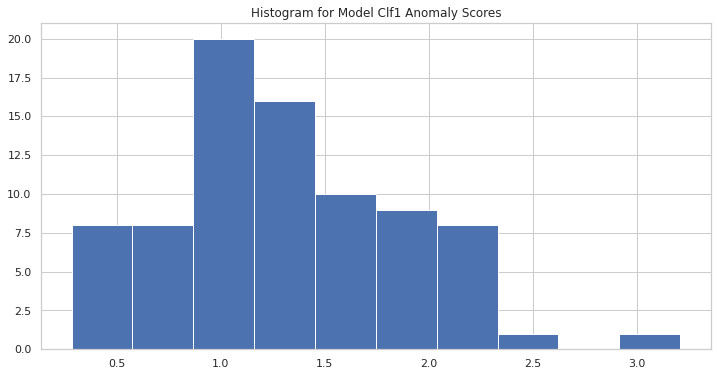

In [ ]:
import matplotlib.pyplot as plt
plt.hist(clf.decision_scores_, bins='auto')
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

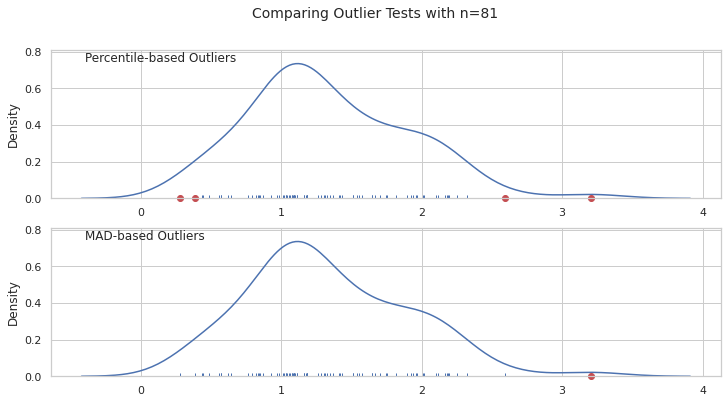

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def main():
  x = clf.decision_scores_
  plot(x)
  plt.show()

def mad_based_outlier(points, thresh=3.5): # Robust Z-score method: 일반적으로 3.5점을 컷오프 값
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def plot(x):
    fig, axes = plt.subplots(nrows=2)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)

main()

In [ ]:
## z_score
def mad_based_outlier(points, thresh=3.5): # Robust Z-score method: 일반적으로 3.5점을 컷오프 값
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score, modified_z_score > thresh

z_scores, outliers = mad_based_outlier(clf.decision_scores_)

print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1 outliers in a total of 81 transactions [1.23%].


In [ ]:
## 백분율 0.95
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold)
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    print(pd.DataFrame(clf.decision_scores_).quantile(0.95))
    return (data < minval) | (data > maxval)

percentile_outliers = percentile_based_outlier(clf.decision_scores_)

0    2.194788
Name: 0.95, dtype: float64


In [ ]:
auto_df['decision_scores'] = clf.decision_scores_
auto_df['datetime1'] = group1['datetime']
auto_df['percentile_outliers'] = percentile_outliers
auto_df.loc[auto_df['percentile_outliers']==True, 'percentile_outliers']  = 1
auto_df.loc[auto_df['percentile_outliers']!=True, 'percentile_outliers']  = 0

auto_df['zscores'] = z_scores
auto_df['zscores_outliers'] = outliers
auto_df.loc[auto_df['zscores_outliers']==True, 'zscores_outliers']  = 1
auto_df.loc[auto_df['zscores_outliers']!=True, 'zscores_outliers']  = 0
auto_df

,pe_repeat,datetime,decision_scores,datetime1,percentile_outliers,zscores,zscores_outliers
0,0.286,737704.0,2.102869,2020-10-06,0,1.780599,0
1,0.098,737727.0,3.208246,2020-10-29,1,3.923639,1
2,0.275,737727.0,2.008723,2020-10-29,0,1.598074,0
3,0.193,737741.0,2.322152,2020-11-12,1,2.205732,0
4,0.385,737748.0,2.180045,2020-11-19,0,1.930223,0
5,0.385,737752.0,2.163172,2020-11-23,0,1.897512,0
6,0.250,737752.0,1.962659,2020-11-23,0,1.508769,0
7,0.439,737752.0,2.591228,2020-11-23,1,2.727401,0
8,0.270,737770.0,1.819851,2020-12-11,0,1.231900,0
9,0.310,737776.0,1.751797,2020-12-17,0,1.099961,0


In [ ]:
auto_df[(auto_df['percentile_outliers']==1) | (auto_df['zscores_outliers']==1)]

,pe_repeat,datetime,decision_scores,datetime1,percentile_outliers,zscores,zscores_outliers
1,0.098,737727.0,3.208246,2020-10-29,1,3.923639,1
3,0.193,737741.0,2.322152,2020-11-12,1,2.205732,0
7,0.439,737752.0,2.591228,2020-11-23,1,2.727401,0
12,0.170,737816.0,2.252891,2021-01-26,1,2.071454,0
38,0.270,738096.0,0.441392,2021-11-02,1,1.440575,0
41,0.280,738117.0,0.282959,2021-11-23,1,1.747736,0
42,0.330,738117.0,0.388630,2021-11-23,1,1.542866,0
52,0.290,738218.0,0.435310,2022-03-04,1,1.452367,0


### #* 모든 변수 for문

In [ ]:
def autoencoder(df):
  result = pd.DataFrame()

  for col in tqdm(df.columns):
    if (col!='검사요청번호') & (col!='datetime'):
      auto_df = df[[col, 'datetime']]
      auto_df['datetime'] = dates.datestr2num(auto_df['datetime'].astype(str).values)
      X_train = StandardScaler().fit_transform(auto_df)
      X_train = pd.DataFrame(X_train)
      
      clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
      clf.fit(X_train)

      result[str(col)] = list(clf.decision_scores_)

  return result

auto_result = autoencoder(df_cor)

  0%|          | 0/16 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
 dropout_6 (Dropout)         (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 2)                 6         
                                                                 
 dropout_7 (Dropout)         (None, 2)                 0         
                                                                 
 dense_9 (Dense)             (None, 25)                75        
                                                                 
 dropout_8 (Dropout)         (None, 25)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                

 12%|█▎        | 2/16 [00:15<01:50,  7.91s/it]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 2)                 6         
                                                                 
 dropout_12 (Dropout)        (None, 2)                 0         
                                                                 
 dense_15 (Dense)            (None, 2)                 6         
                                                                 
 dropout_13 (Dropout)        (None, 2)                 0         
                                                                 
 dense_16 (Dense)            (None, 25)                75        
                                                                 
 dropout_14 (Dropout)        (None, 25)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                

 19%|█▉        | 3/16 [00:28<02:08,  9.89s/it]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 2)                 6         
                                                                 
 dropout_18 (Dropout)        (None, 2)                 0         
                                                                 
 dense_22 (Dense)            (None, 2)                 6         
                                                                 
 dropout_19 (Dropout)        (None, 2)                 0         
                                                                 
 dense_23 (Dense)            (None, 25)                75        
                                                                 
 dropout_20 (Dropout)        (None, 25)                0         
                                                                 
 dense_24 (Dense)            (None, 2)                

 25%|██▌       | 4/16 [00:35<01:47,  8.98s/it]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 2)                 6         
                                                                 
 dropout_24 (Dropout)        (None, 2)                 0         
                                                                 
 dense_29 (Dense)            (None, 2)                 6         
                                                                 
 dropout_25 (Dropout)        (None, 2)                 0         
                                                                 
 dense_30 (Dense)            (None, 25)                75        
                                                                 
 dropout_26 (Dropout)        (None, 25)                0         
                                                                 
 dense_31 (Dense)            (None, 2)                

3/3 [==============================] - 0s 6ms/step


 31%|███▏      | 5/16 [00:43<01:32,  8.42s/it]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 2)                 6         
                                                                 
 dropout_30 (Dropout)        (None, 2)                 0         
                                                                 
 dense_36 (Dense)            (None, 2)                 6         
                                                                 
 dropout_31 (Dropout)        (None, 2)                 0         
                                                                 
 dense_37 (Dense)            (None, 25)                75        
                                                                 
 dropout_32 (Dropout)        (None, 25)                0         
                                                                 
 dense_38 (Dense)            (None, 2)                

3/3 [==============================] - 0s 5ms/step


 38%|███▊      | 6/16 [00:55<01:37,  9.73s/it]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 2)                 6         
                                                                 
 dropout_36 (Dropout)        (None, 2)                 0         
                                                                 
 dense_43 (Dense)            (None, 2)                 6         
                                                                 
 dropout_37 (Dropout)        (None, 2)                 0         
                                                                 
 dense_44 (Dense)            (None, 25)                75        
                                                                 
 dropout_38 (Dropout)        (None, 25)                0         
                                                                 
 dense_45 (Dense)            (None, 2)                

 44%|████▍     | 7/16 [01:02<01:20,  8.95s/it]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 2)                 6         
                                                                 
 dropout_42 (Dropout)        (None, 2)                 0         
                                                                 
 dense_50 (Dense)            (None, 2)                 6         
                                                                 
 dropout_43 (Dropout)        (None, 2)                 0         
                                                                 
 dense_51 (Dense)            (None, 25)                75        
                                                                 
 dropout_44 (Dropout)        (None, 25)                0         
                                                                 
 dense_52 (Dense)            (None, 2)                

 50%|█████     | 8/16 [01:10<01:08,  8.53s/it]

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 2)                 6         
                                                                 
 dropout_48 (Dropout)        (None, 2)                 0         
                                                                 
 dense_57 (Dense)            (None, 2)                 6         
                                                                 
 dropout_49 (Dropout)        (None, 2)                 0         
                                                                 
 dense_58 (Dense)            (None, 25)                75        
                                                                 
 dropout_50 (Dropout)        (None, 25)                0         
                                                                 
 dense_59 (Dense)            (None, 2)                

 56%|█████▋    | 9/16 [01:18<00:58,  8.37s/it]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 2)                 6         
                                                                 
 dropout_54 (Dropout)        (None, 2)                 0         
                                                                 
 dense_64 (Dense)            (None, 2)                 6         
                                                                 
 dropout_55 (Dropout)        (None, 2)                 0         
                                                                 
 dense_65 (Dense)            (None, 25)                75        
                                                                 
 dropout_56 (Dropout)        (None, 25)                0         
                                                                 
 dense_66 (Dense)            (None, 2)                

 62%|██████▎   | 10/16 [01:26<00:48,  8.10s/it]

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 2)                 6         
                                                                 
 dropout_60 (Dropout)        (None, 2)                 0         
                                                                 
 dense_71 (Dense)            (None, 2)                 6         
                                                                 
 dropout_61 (Dropout)        (None, 2)                 0         
                                                                 
 dense_72 (Dense)            (None, 25)                75        
                                                                 
 dropout_62 (Dropout)        (None, 25)                0         
                                                                 
 dense_73 (Dense)            (None, 2)               

 69%|██████▉   | 11/16 [01:35<00:41,  8.38s/it]

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 2)                 6         
                                                                 
 dropout_66 (Dropout)        (None, 2)                 0         
                                                                 
 dense_78 (Dense)            (None, 2)                 6         
                                                                 
 dropout_67 (Dropout)        (None, 2)                 0         
                                                                 
 dense_79 (Dense)            (None, 25)                75        
                                                                 
 dropout_68 (Dropout)        (None, 25)                0         
                                                                 
 dense_80 (Dense)            (None, 2)               

 75%|███████▌  | 12/16 [01:49<00:40, 10.08s/it]

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 2)                 6         
                                                                 
 dropout_72 (Dropout)        (None, 2)                 0         
                                                                 
 dense_85 (Dense)            (None, 2)                 6         
                                                                 
 dropout_73 (Dropout)        (None, 2)                 0         
                                                                 
 dense_86 (Dense)            (None, 25)                75        
                                                                 
 dropout_74 (Dropout)        (None, 25)                0         
                                                                 
 dense_87 (Dense)            (None, 2)               

 81%|████████▏ | 13/16 [02:01<00:32, 10.86s/it]

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 2)                 6         
                                                                 
 dropout_78 (Dropout)        (None, 2)                 0         
                                                                 
 dense_92 (Dense)            (None, 2)                 6         
                                                                 
 dropout_79 (Dropout)        (None, 2)                 0         
                                                                 
 dense_93 (Dense)            (None, 25)                75        
                                                                 
 dropout_80 (Dropout)        (None, 25)                0         
                                                                 
 dense_94 (Dense)            (None, 2)               

 88%|████████▊ | 14/16 [02:10<00:20, 10.17s/it]

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 2)                 6         
                                                                 
 dropout_84 (Dropout)        (None, 2)                 0         
                                                                 
 dense_99 (Dense)            (None, 2)                 6         
                                                                 
 dropout_85 (Dropout)        (None, 2)                 0         
                                                                 
 dense_100 (Dense)           (None, 25)                75        
                                                                 
 dropout_86 (Dropout)        (None, 25)                0         
                                                                 
 dense_101 (Dense)           (None, 2)               

100%|██████████| 16/16 [02:18<00:00,  8.65s/it]


In [ ]:
auto_result

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
0,2.374822,2.225985,2.189364,2.400715,2.223158,2.515504,2.295621,2.990813,2.078305,2.215767,2.591623,2.517828,2.334295,2.478876
1,2.220188,2.183450,2.009263,2.516878,2.146681,2.654652,2.210902,2.646765,3.138022,2.108410,2.344639,2.244919,2.801407,2.903541
2,2.078902,2.082613,2.068767,2.257894,2.187619,2.237744,2.185856,2.912731,1.983055,2.067961,2.326401,2.161716,2.584164,2.330314
3,2.109599,2.539891,1.958262,2.216442,2.023019,2.171108,2.128588,4.130275,2.277998,2.001302,2.193428,2.000316,2.137811,2.153529
4,2.036427,2.113749,2.014822,2.257930,2.080292,2.321125,2.097449,2.570322,2.173447,1.941964,2.064080,2.001079,2.156894,2.113253
5,2.059105,2.933009,1.965844,2.637275,2.048896,2.353211,2.144439,3.127810,2.156770,1.934952,2.025481,2.286703,2.403707,2.068879
6,2.163065,2.065652,2.030870,2.177774,2.048896,2.203317,2.095487,2.312390,1.938172,1.922615,2.016131,1.948046,2.069316,2.089283
7,2.017711,3.023140,2.013288,2.573297,2.062448,2.721700,2.094360,5.511188,2.594863,1.931340,2.553904,1.946471,2.639534,2.282583
8,3.907801,2.212372,1.989720,1.971009,1.941716,1.971857,1.997578,1.868756,1.787968,1.839207,2.089421,2.438921,2.083228,2.057126
9,1.870027,2.370438,1.801925,2.132668,1.914670,2.081078,1.968661,1.840790,1.727122,1.810228,2.232445,2.642871,2.418184,2.256642


In [ ]:
## z-score
def plot(x):
  def mad_based_outlier(points, thresh=3.5): # Robust Z-score method: 일반적으로 3.5점을 컷오프 값
      if len(points.shape) == 1:
          points = points[:,None]
      median = np.median(points, axis=0)
      diff = np.sum((points - median)**2, axis=-1)
      diff = np.sqrt(diff)
      med_abs_deviation = np.median(diff)

      modified_z_score = 0.6745 * diff / med_abs_deviation

      return modified_z_score > thresh

  ## 백분율 0.95
  def percentile_based_outlier(data, threshold=95):
      diff = (100 - threshold) / 2.0
      minval, maxval = np.percentile(data, [diff, 100 - diff])
      return (data < minval) | (data > maxval)

  fig, axes = plt.subplots(nrows=2)
  for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier]): # [백분율 0.95, z-score]
      sns.distplot(x, ax=ax, rug=True, hist=False)
      outliers = x[func(x)]
      ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

  kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
  axes[0].set_title('Percentile-based Outliers', **kwargs)
  axes[1].set_title('MAD-based Outliers', **kwargs)
  fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)

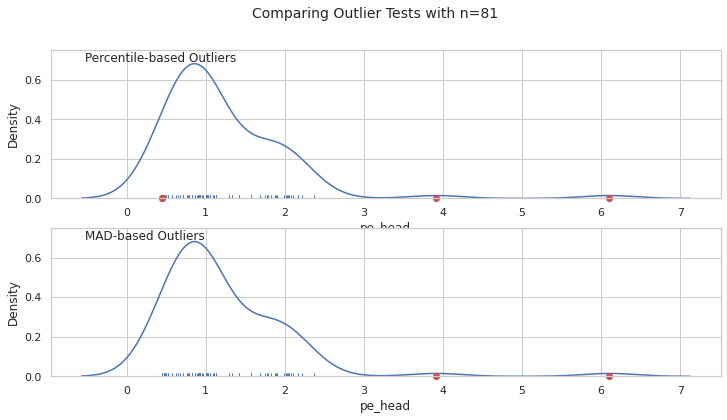

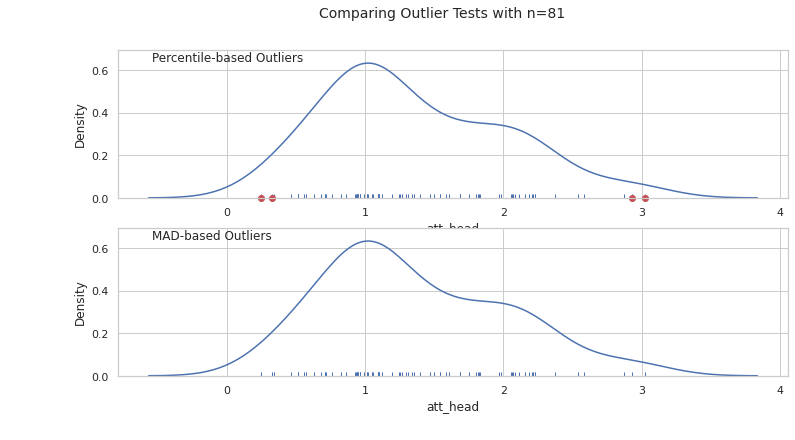

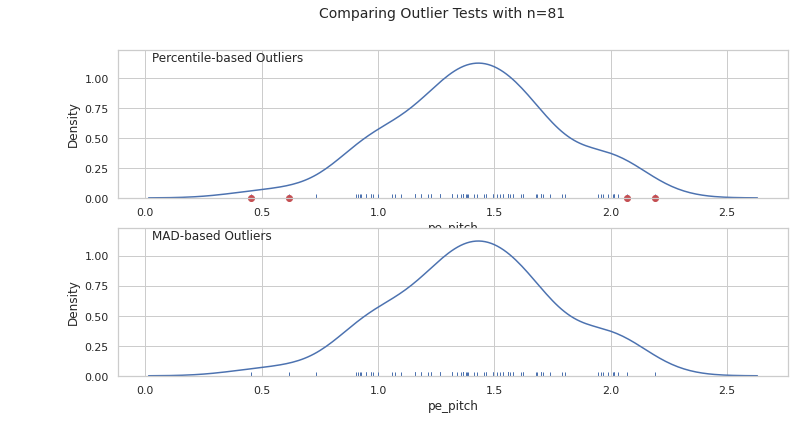

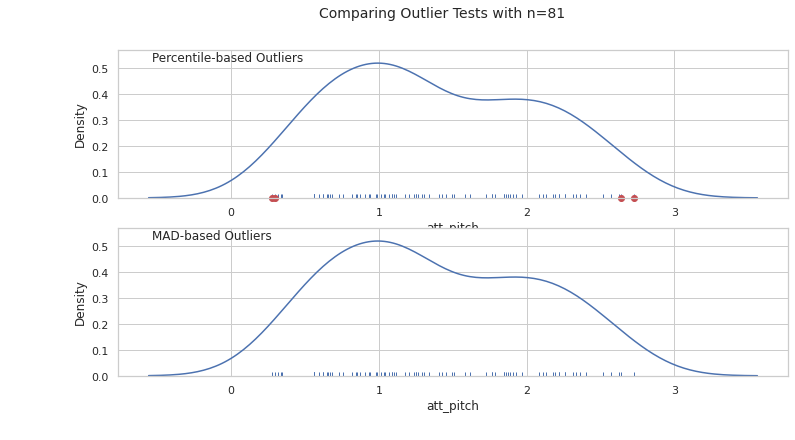

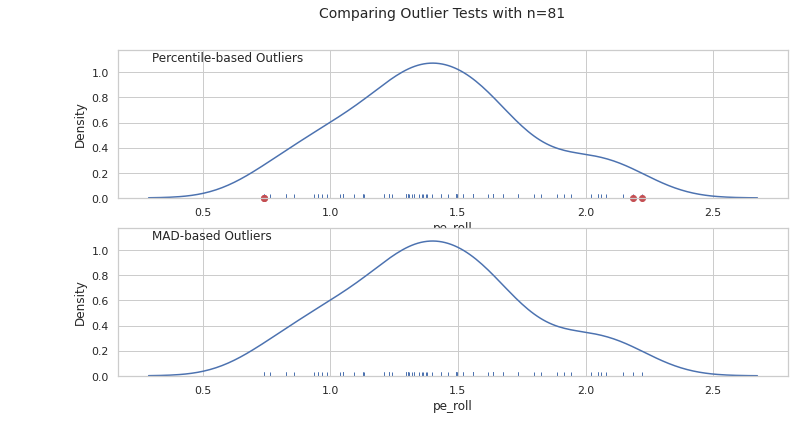

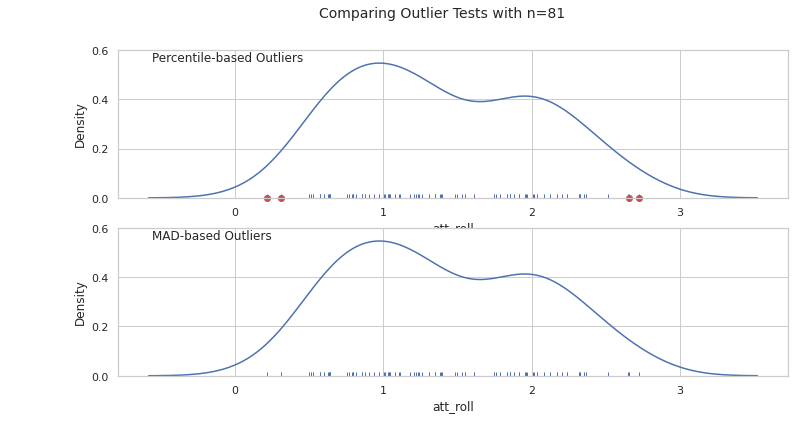

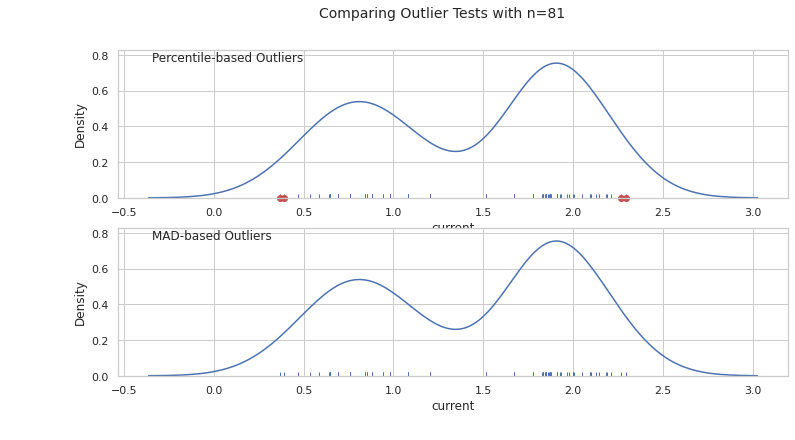

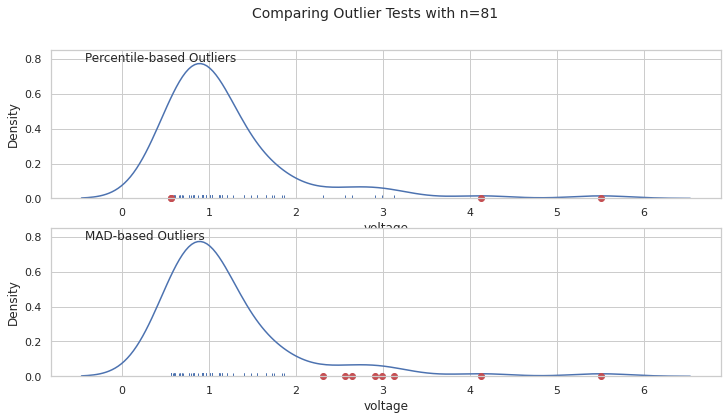

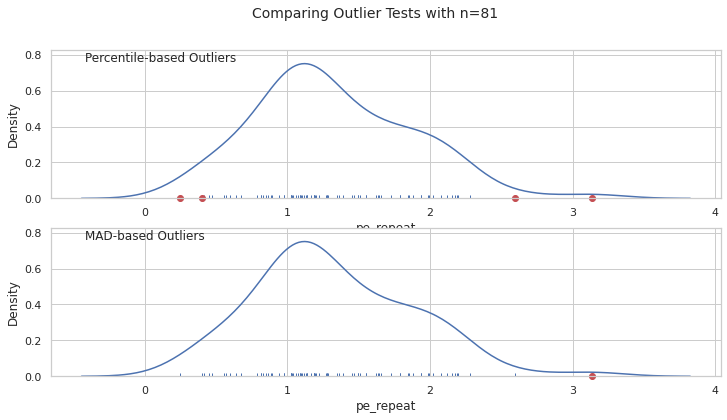

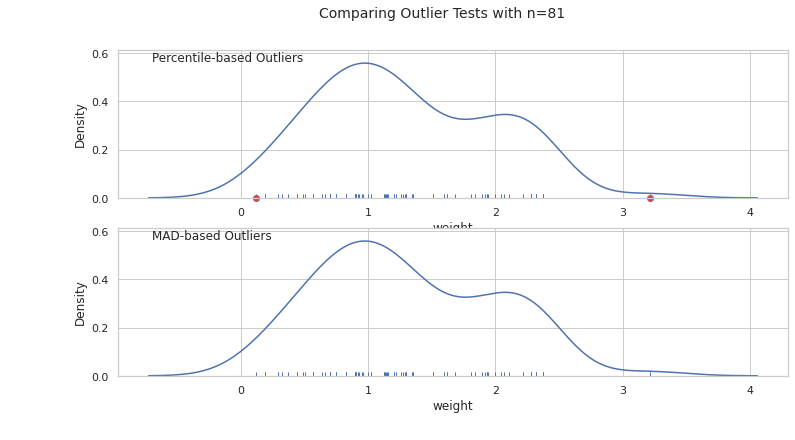

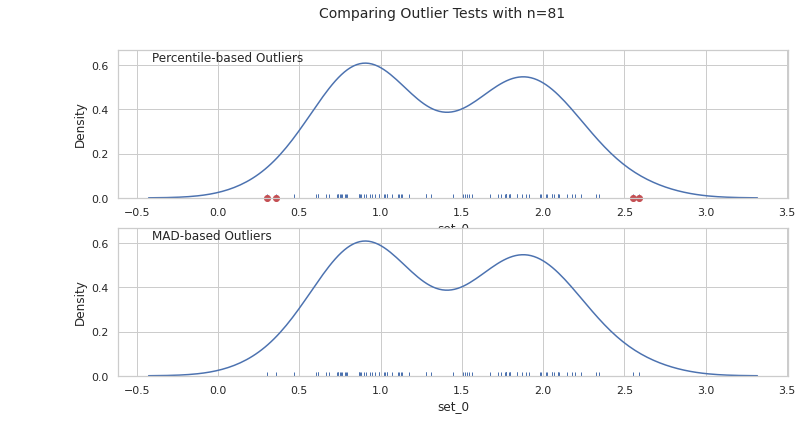

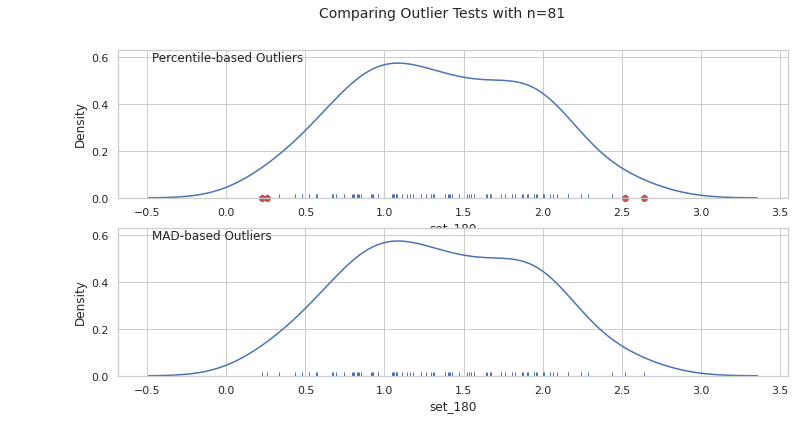

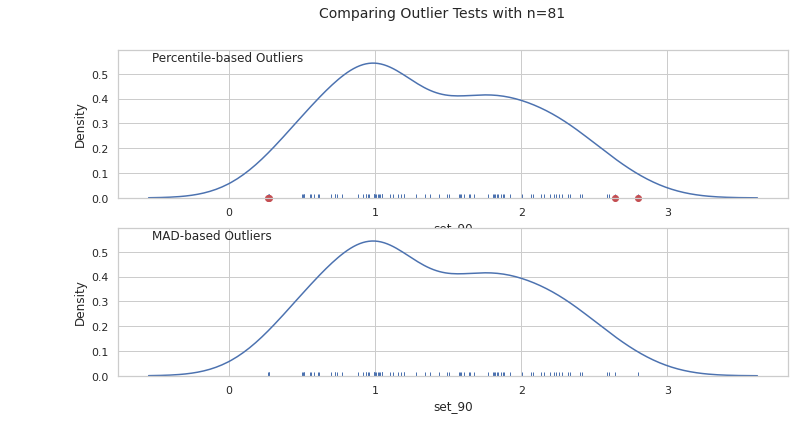

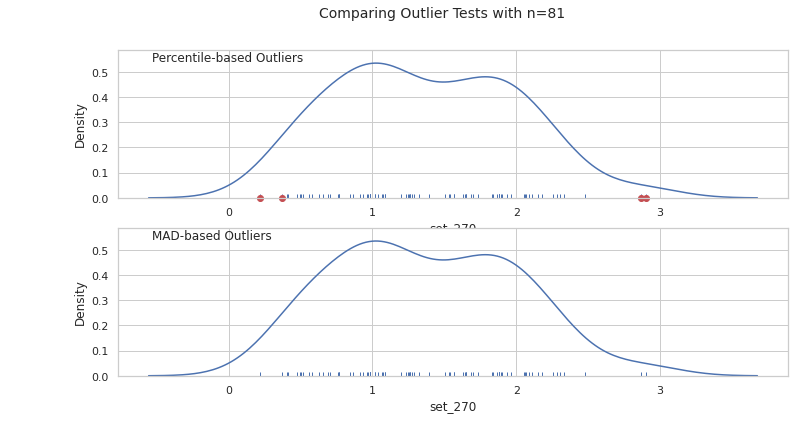

In [ ]:
for col in auto_result.columns:
  plot(auto_result[col])

In [ ]:
## z_score
def mad_based_outlier(points, thresh=3.5): # Robust Z-score method: 일반적으로 3.5점을 컷오프 값
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score, modified_z_score > thresh

print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

## 백분율 0.95
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold)
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    # print(pd.DataFrame(clf.decision_scores_).quantile(0.95))
    return (data < minval) | (data > maxval)

Detected 1 outliers in a total of 81 transactions [1.23%].


In [ ]:
auto_df = pd.DataFrame()

for col in auto_result.iloc[:,:14].columns:
  
  loop_df = pd.DataFrame(columns=['col'])

  loop_df['decision_scores'] = auto_result[col]
  loop_df['percentile_outliers'] = percentile_based_outlier(auto_result[col].values)
  loop_df.loc[loop_df['percentile_outliers']==True, 'percentile_outliers']  = 1
  loop_df.loc[loop_df['percentile_outliers']!=True, 'percentile_outliers']  = 0

  z_scores, outliers = mad_based_outlier(auto_result[col].values)
  loop_df['zscores'] = z_scores
  loop_df['zscores_outliers'] = outliers
  loop_df.loc[loop_df['zscores_outliers']==True, 'zscores_outliers']  = 1
  loop_df.loc[loop_df['zscores_outliers']!=True, 'zscores_outliers']  = 0
  loop_df['col'] = col

  auto_df = pd.concat([auto_df, loop_df])

auto_df['datetime'] = df_num['datetime']
auto_df = auto_df.reset_index(drop=True)
auto_df

,col,decision_scores,percentile_outliers,zscores,zscores_outliers,datetime
0,pe_head,2.374822,1,2.963934,0,2020-10-06
1,pe_head,2.220188,1,2.642797,0,2020-10-29
2,pe_head,2.078902,0,2.349381,0,2020-10-29
3,pe_head,2.109599,0,2.413132,0,2020-11-12
4,pe_head,2.036427,0,2.261171,0,2020-11-19
5,pe_head,2.059105,0,2.308268,0,2020-11-23
6,pe_head,2.163065,0,2.524168,0,2020-11-23
7,pe_head,2.017711,0,2.222303,0,2020-11-23
8,pe_head,3.907801,1,6.147550,1,2020-12-11
9,pe_head,1.870027,0,1.915600,0,2020-12-17


In [ ]:
auto_df[auto_df['zscores_outliers']==1].groupby(['datetime'])['zscores_outliers'].count()

datetime
2020-10-06    1
2020-10-29    3
2020-11-12    1
2020-11-19    1
2020-11-23    3
2020-12-11    1
2022-06-08    1
Name: zscores_outliers, dtype: int64

In [ ]:
auto_df[auto_df['percentile_outliers']==1].groupby(['col'])['percentile_outliers'].count()

col
att_head     8
att_pitch    8
att_roll     8
current      8
pe_head      6
pe_pitch     8
pe_repeat    8
pe_roll      7
set_0        8
set_180      8
set_270      8
set_90       8
voltage      6
weight       8
Name: percentile_outliers, dtype: int64

In [ ]:
auto_df[(auto_df['percentile_outliers']==1) & (auto_df['zscores_outliers']==1)].groupby(['datetime','col'])['percentile_outliers'].count()

datetime    col      
2020-10-06  voltage      1
2020-10-29  pe_repeat    1
2020-11-12  voltage      1
2020-11-23  voltage      2
2020-12-11  pe_head      1
2022-06-08  pe_head      1
Name: percentile_outliers, dtype: int64

In [ ]:
def date_index(export, groupby):
  count = pd.DataFrame(groupby)
  # export.columns = ['count']
  # export = export.reset_index()
  # export['datetime'] = export['datetime'].astype(str)
  # export = export.set_index('datetime')
  export2 = pd.merge(export, count,left_index=True, right_index=True, how='left')

  return export2

date_index(export, auto_df[auto_df['zscores_outliers']==1].groupby(['datetime'])['zscores_outliers'].count())#.to_csv('/content/drive/MyDrive/학교/LAB/date3.csv')

,count,zscores_outliers
datetime,,
2020-10-06,1,NaN
2020-10-29,2,NaN
2020-11-12,1,NaN
2020-11-19,1,NaN
2020-11-23,3,NaN
2020-12-11,1,NaN
2020-12-17,1,NaN
2021-01-06,1,NaN
2021-01-12,1,NaN


## 최종

In [ ]:
prophet_df.reset_index(drop=True).groupby(['ds'])[['col']].count()

In [ ]:
auto_df[auto_df['zscores_outliers']==1].groupby(['col'])['zscores_outliers'].count()

## (6) 이동평균

In [ ]:
average_df = group1[['pe_repeat', 'datetime']].set_index('datetime')
average_df.plot()

In [ ]:
def moving_average(data, window_size):

    window = np.ones(int(window_size))/float(window_size)
    
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
  avg = moving_average(y, window_size).tolist()
  residual = y - avg
  # Calculate the variation in the distribution of the residual
  std = np.std(residual)
  return {'standard_deviation': round(std, 3), 
            'anomalies_dict': collections.OrderedDict([(index, y_i) for 
                                                       index, y_i, avg_i in izip(count(), y, avg) 
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [ ]:
# moving_average(average_df['pe_repeat'].values, 3)
window_size = 3
window = np.ones(int(window_size))/float(window_size)
average_df['pe_repeat'].values

In [ ]:
0.098+0.098

In [ ]:
np.convolve(average_df['pe_repeat'].values, [1,1], 'same')

In [ ]:
# sample_size = len(df)
# predicted_y = []

# df_train = df[df.index < 2015] # 학습데이터

def moving_average(df, window_size):
  window = len(df_train) # 윈도우 사이즈 설정 (2002~2015)

  # df_test = df[df.index >= 2015] #검증데이터
  # forecast_horizon = len(df_test) # 검증데이터 길이

  start_index = 0

  # fit the model and make a forecast
  for i in tqdm(range(forecast_horizon)):
      # writer = SummaryWriter()

      end_index = start_index + window 
      new_data = df.iloc[start_index : end_index] # df에서 end_index+1

      x_train, x_val, y_train, y_val = train_test_split(new_data.drop(["Y"], axis =1), new_data["Y"] ,test_size = 0.25, shuffle = False)

      # gets the trained neural network with given data
      model = 

      x_new = df.iloc[end_index]
      x_new = pd.DataFrame(x_new).T.drop(["Y"], axis = 1)
      y_pred = model.predict(x_new)
      # y_pred = y_pred[0][0]    

      predicted_y.append(y_pred)

      start_index = start_index + 1 # for rolling-window forecasts

      # window = window + 1 # for recursive forecasts

# #3. 이상치 탐지방법 별 모든 변수에 대한 이상치 탐지 파이프라인 또는 class

- 하나의 변수에서라도 이상치가 나오면 해당시간관측치값은 abnormal로 간주
- random값만들어서 성능평가

In [ ]:
X = df_dup.drop(['검사요청번호', 'datetime'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)

In [ ]:
# 임의의 이상치 데이터 생성 방법
import random
X = []

want_noise_col = 40
for noise_col in range(0, want_noise_col):
    noise_row = [round(random.uniform(0.0, 0.5), 5) for col_num in range(len(group2.columns)-1)]
    X.append(noise_row)

X = pd.DataFrame(X, columns=group2.columns[0:3])
X['class'] = 1